#### Objective - To build a model to recommend electronic gadgets to users of Amazon.
#Approach - Building a popularity based recommender system and a collaborative filtering based recommendation system to arrive at the top 5 product recommendations for the users.
#Models built - 
1. Popularity based recommendation system (For products that have been purchased more than 10 times)
- Popularity based recommender system, suggests the same products to all users, based on the highest average ratings. Accordingly I have not splitting the data into train and test set for building a recommendation system based on popularity. I have created a dataframe by grouping the products, adding a column for the average rating and sorting the product recommendation based on the average rating in descending order to arrive at the top 5 recommendations. The recommendations are going to be constant for all users as the user preferences are not considered while building a model based on average rating.

2. Collaborative filtering based recommendation system
- Built an item - item collaborative filtering model for items that have been purchased greater than 500 times. (considered items over purchased over 500 times as I couldn't process the c.8 million line items due to memory error. I, however, initially, planned to build a model for all items that were purchased more than 100 times. Refer screen shot attached for more details)

- Considering, I had a good RMSE score (1.3) for the predictions on the test data I built predictions for the entire data set and grouped by and filtered for the top 5 recommendations for each customers. (Experienced error on attempting to built a matrix factorisation model as I could not build a pivot for all possible combinations of user and product, arrive at the estimated rating value using the model built and building recommendations based on the entire product pool for all customers. So I have built a recommendation model on the existing user - product combination and the recommendations won't include products that the user has never purchased even if it is the most valuable recommendation. Refer screen shot attached for more details)

#Observations - The recommendations based on popularity based recommendations systems are rigid and doesn't consider the user preference into account, whereas the collaborative filtering based recommendations system provides different, personalised recommendations based on their purchase history. Accordingly, I have presented my recommendations below separately for popularity based and collaborative filtering based recommendations systems. 

Note: I wasn't able to build a user - user collaborative filtering model for recommendations as I was getting memory error on all combinations of reducted data I tried working on. Please refer the screen shot attached for further details.

In [1]:
# importing pandas and numpy to import the data set and work on data frames and arrays
import pandas as pd
import numpy as np

# importing matplotlib plotting libraries
import matplotlib.pyplot as plt

# to enable plotting graphs in jupyter notebooks
%matplotlib inline

# importing seaborn for statistical plots
import seaborn as sns

# importing packages from surprise to building collaborative filtering based recommendation models.
import surprise as sp
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.reader import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
# Importing and visualising the data
Ratings_Data = pd.read_csv('ratings_Electronics.csv', names = ['user_id', 'product_id', 'rating', 'timestamp'])
Ratings_Data.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
#Checking for the attributes of the data
Ratings_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
user_id       object
product_id    object
rating        float64
timestamp     int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
# Including columns for user count and product count
Ratings_Data['user_count'] = Ratings_Data.groupby('user_id')['user_id'].transform('count')
Ratings_Data['product_count'] = Ratings_Data.groupby('product_id')['product_id'].transform('count')
Ratings_Data.head()

,user_id,product_id,rating,timestamp,user_count,product_count
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2,1
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,4,1
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,1,3
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,1,3
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,1,3


In [5]:
# Dropping the timestamp column
Ratings_data = Ratings_Data.copy()
Ratings_data.drop(columns = 'timestamp', inplace = True)

In [6]:
# plotting the 5 number summary for the data
Ratings_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.380910,1.0,3.0,5.0,5.0,5.0
user_count,7824482.0,6.332077,17.594918,1.0,1.0,2.0,5.0,520.0
product_count,7824482.0,789.154791,1984.079023,1.0,32.0,149.0,602.0,18244.0


In [7]:
# Dropping movies that have been watched less than 10 times
Ratings_data.drop(Ratings_data[Ratings_data['product_count']<10].index, inplace = True)
# Printing the shape of the data
Ratings_data.shape

(6878784, 5)

In [8]:
# plotting the 5 number summary for the data
Ratings_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,6878784.0,4.031741,1.368673,1.0,4.0,5.0,5.0,5.0
user_count,6878784.0,6.298102,17.501257,1.0,1.0,2.0,5.0,520.0
product_count,6878784.0,897.071892,2093.182458,10.0,59.0,207.0,735.0,18244.0


C:\Users\Jarvis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


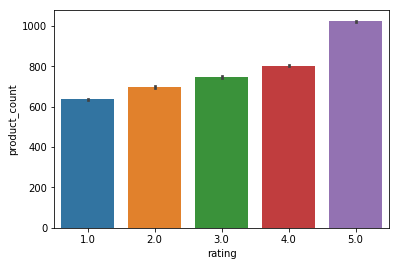

In [9]:
# Using bar plots to visualise the distribution of products based on their rating
pc = sns.barplot(x = 'rating', y = 'product_count', data = Ratings_data)

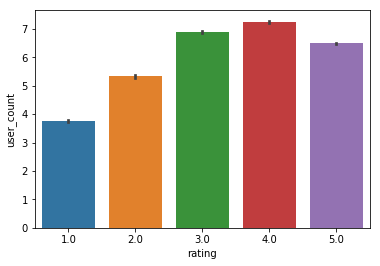

In [10]:
# Using bar plots to visualise the distribution of users based on rating they gave for different movies
uc = sns.barplot(x = 'rating', y = 'user_count', data = Ratings_data)

#### Building a popularity based recommender system. Popularity based recommender system, suggests the same products to all users, based on the highest average ratings. Accordingly I am not splitting the data into train and test set for building a recommendation system based on popularity. I am creating a dataframe by grouping the products, adding a column for the average rating and sorting the product recommendation based on the average rating in descending order

In [11]:
#Creating a copy of the data
RS_Popularity = Ratings_data.copy()

# Dropping the user_id column as it is irrelavant
RS_Popularity.drop(columns = "user_id", inplace = True)

# Grouping by the product_id and computing the average rating for the product along with the count of number of ratings
RS_Popularity_Recommender = pd.DataFrame(RS_Popularity.groupby('product_id')['rating'].mean()) 
RS_Popularity_Recommender['rating_counts'] = pd.DataFrame(RS_Popularity.groupby('product_id')['rating'].count())

# Sorting the order of the table by highest rating
RS_Popularity_Recommender.sort_values(by = 'rating', ascending = False, inplace = True)

# Printing the top 5 recommendations of the product for all users
RS_Popularity_Recommender.head(5)

,rating,rating_counts
product_id,,
B005QQHKB0,5.0,11
B004BYPLNM,5.0,15
B00644G4QK,5.0,11
B0012VT1QK,5.0,14
B00FA7DLE0,5.0,10


##### As found in the table above, the same set of products will be recommended to all customers irrespective of the rating count, user preference or the product they are searching for. This is one of the short comings of a popularity based recommendation system.

### Building an item based collaborative filtering model

#### since I am getting a memory error I am limiting my analysis to products that were rated more than 500 times

In [12]:
# Preparing the data to recommendation system builder packages from surprise
Ratings_data_reducted = Ratings_data.copy()
Ratings_data_reducted.drop(Ratings_data_reducted[Ratings_data_reducted['product_count']<500].index, inplace = True)
Ratings_data_reducted.shape

(2203944, 5)

In [13]:
# Splitting the data in training and testing set
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Ratings_data_reducted[['user_id', 'product_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 6)

In [14]:
# Fitting the algorithm to learn patterns from the training set
algo_item = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_item.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [15]:
# runing the trained model against the testset to estimate the ratings
test_pred_item = algo_item.test(test_data)

In [16]:
test_pred_item

[Prediction(uid='A1VT691JQCQW4F', iid='B0026ZPFCK', r_ui=5.0, est=4.719291340244479, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A34YLD7C9J39BK', iid='B0015DYMVO', r_ui=5.0, est=4.171090124193005, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='ASXKI6YV3JET1', iid='B00728ZBA2', r_ui=5.0, est=4.171090124193005, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A00473363TJ8YSZ3YAGG9', iid='B00CTUIT20', r_ui=4.0, est=2.256275893273758, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2WMOTSHINOJQR', iid='B003ES5ZUU', r_ui=5.0, est=4.171090124193005, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A214PATZBRO7SB', iid='B001TH7GUU', r_ui=4.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A3Q53OJCB32KAZ', iid='B006T9B6R2', r_ui=5.0, est=4.171090124193005, details={'was_impossible': True, '

In [18]:
# Evaluating the accuracy of the model based on the RMSE score
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_item, verbose=True)

Item-based Model : Test Set
RMSE: 1.2957


1.295660486423495

In [19]:
# Preparing to total raw data to run the collaborative filtering model on to come up with recommendations out of the maximum 
# possible products for all the users.
reader = Reader(rating_scale=(1, 5))
data_users = Dataset.load_from_df(Ratings_Data[['user_id', 'product_id', 'rating']], reader)
train_data_users, test_data_users = train_test_split(data_users, test_size = 0.999, random_state = 6)
predictions_all_users = algo_item.test(test_data_users)

In [ ]:
# Printing the predictions as a dataframe.
top_predictions = pd.DataFrame(predictions_all_users)
top_predictions.head()

,uid,iid,r_ui,est,details
0,A35PG7I9KEJ2CS,B000X1P5RE,5.0,4.17109,"{'was_impossible': True, 'reason': 'User and/o..."
1,A8SRL4499EYP,B00622AG6S,5.0,4.17109,"{'was_impossible': True, 'reason': 'User and/o..."
2,A1USDNG8HBXCDF,B000069V00,5.0,4.17109,"{'was_impossible': True, 'reason': 'User and/o..."
3,AI3P4P2PX4O8P,B000RZQZM0,5.0,4.17109,"{'was_impossible': True, 'reason': 'User and/o..."
4,A2M7AO9JU10IPQ,B00COYOAYW,4.0,4.00000,"{'actual_k': 1, 'was_impossible': False}"


In [ ]:
# Printing the top 5 recommendations for each user
top5_predictions = top_predictions.groupby('uid')['est'].nlargest(5)

Ideally I would have run the model for all possible combinations of product and customer to arrive at the top 5 predictions for all the users from the entire range of products listed in the website. However, I was not able to run a pivot to list all possible user - product combinations to recommend the best products that the customer is most likely to buy. So I have built a recommendation model on the existing user - product combination and the recommendations won't include products that the user has never purchased even if it is the most valuable recommendation.